In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
# Libraries
print("\tImporting libraries...\n")
import sys; sys.path.append("..")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

# ml libraries

# dl libraries
import torch

# ext. libraries
import src.utils as utils
from src.helper import HeaParser
print("\tImport complete!\n")

utils.set_plt_style()
device = utils.get_device_info()
seed = utils.set_all_seeds()

NUM_WORKERS = 23
DATASET_NAME = "mimic-iv-ecg"
DATASET_DIR = os.path.join("..", "data", DATASET_NAME)
# OUTPUT_DIR = os.path.join("..", "out", DATASET_NAME)

	Importing libraries...


=== Environment Information ===
Python version: 3.12.2
PyTorch version: 2.6.0
NumPy version: 1.26.4
Platform: macOS-15.4.1-arm64-arm-64bit



Seed set to 42


	Import complete!


=== Device Information ===
CUDA available: False
Using device: cpu


=== Setting Random Seeds ===
Seed value: 42
Setting torch CPU seed...
Setting torch CUDA seed...
Setting numpy seed...
Configuring CUDNN...
Configuring PL...



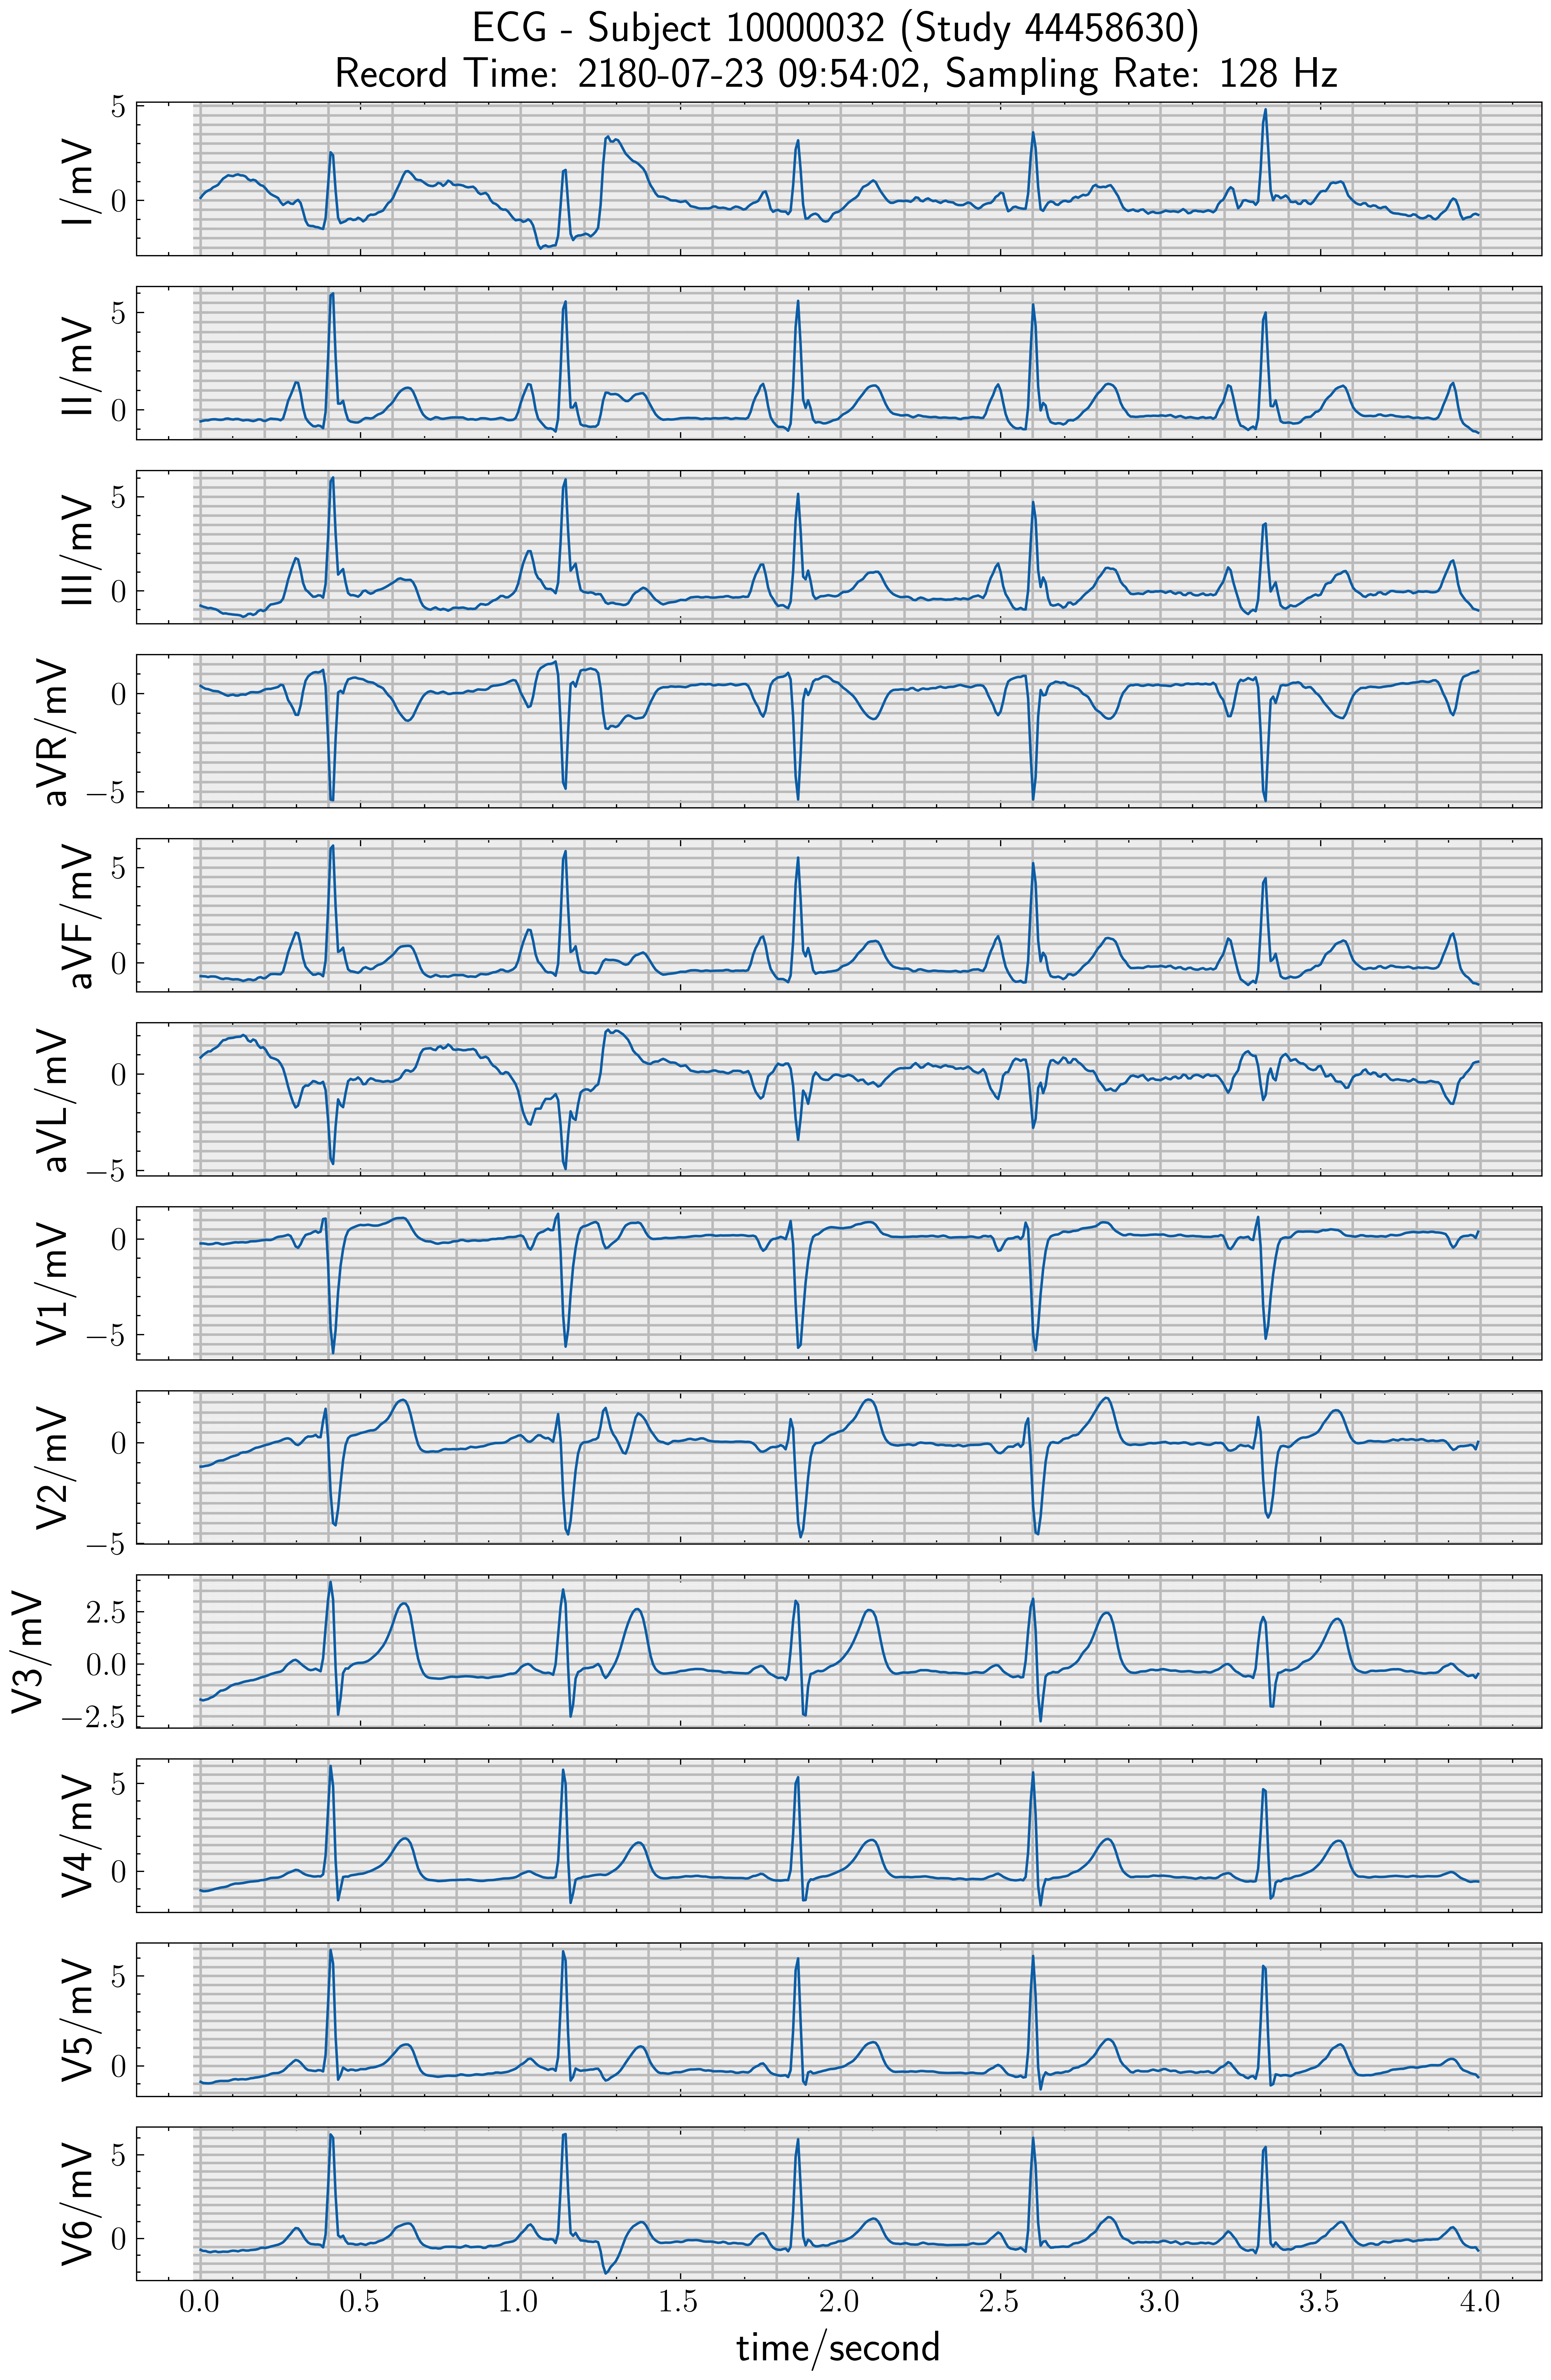

In [3]:
# NOTE: change to your own path to p1000-p1007 folders
base_dir = "/Volumes/Black/Data/ecg4kca/mimic-iv-ecg/1.0/files"  

parser = HeaParser(base_dir)

subject_id = "10000032"
study_id = "44458630"
record = parser.parse(subject_id, study_id, plot=True)

# subject_id = "10000032"
# study_id = "40689238"
# record = parser.parse(subject_id, study_id, plot=True)

# subject_id = "10000764"
# study_id = "40539087"
# record = parser.parse(subject_id, study_id, plot=True)

# subject_id = "10000826"
# study_id = "40695233"
# record = parser.parse(subject_id, study_id, plot=True)


In [4]:
# read from the excel file (record -> K and Ca)
data = pd.read_excel(os.path.join(DATASET_DIR, "data_baoliuxiaoshu.xlsx"))
X = torch.tensor([])
y = torch.tensor([])

for subject_id, study_id, k, ca in zip(
    data["subject_id"], data["study_id"], data["potassium"], data["calcium"]
):
    signal = parser.parse(str(subject_id), str(study_id)).p_signal
    x = torch.tensor(signal, dtype=torch.float32).T # (channels, timepoints)
    kca = torch.tensor([k, ca], dtype=torch.float32)
    X = torch.cat([X, x.unsqueeze(0)], dim=0) # (N, C, T)
    y = torch.cat([y, kca.unsqueeze(0)], dim=0)

/Users/juntangwang/Library/CloudStorage/OneDrive-DukeUniversity/Documents/_Projects/ecg4kca/notebook/../src/helper.py:88: UserWarning: No peak > 2.5 found, using any peak
  warnings.warn("No peak > 2.5 found, using any peak")


In [5]:
# train-test split (0.8)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 # fixed here
)

print(f"Train set size: {X_train.shape} \t with y shape: {y_train.shape}")
print(f"Test  set size: {X_test.shape} \t with y shape: {y_test.shape}")

Train set size: torch.Size([1536, 12, 512]) 	 with y shape: torch.Size([1536, 2])
Test  set size: torch.Size([385, 12, 512]) 	 with y shape: torch.Size([385, 2])


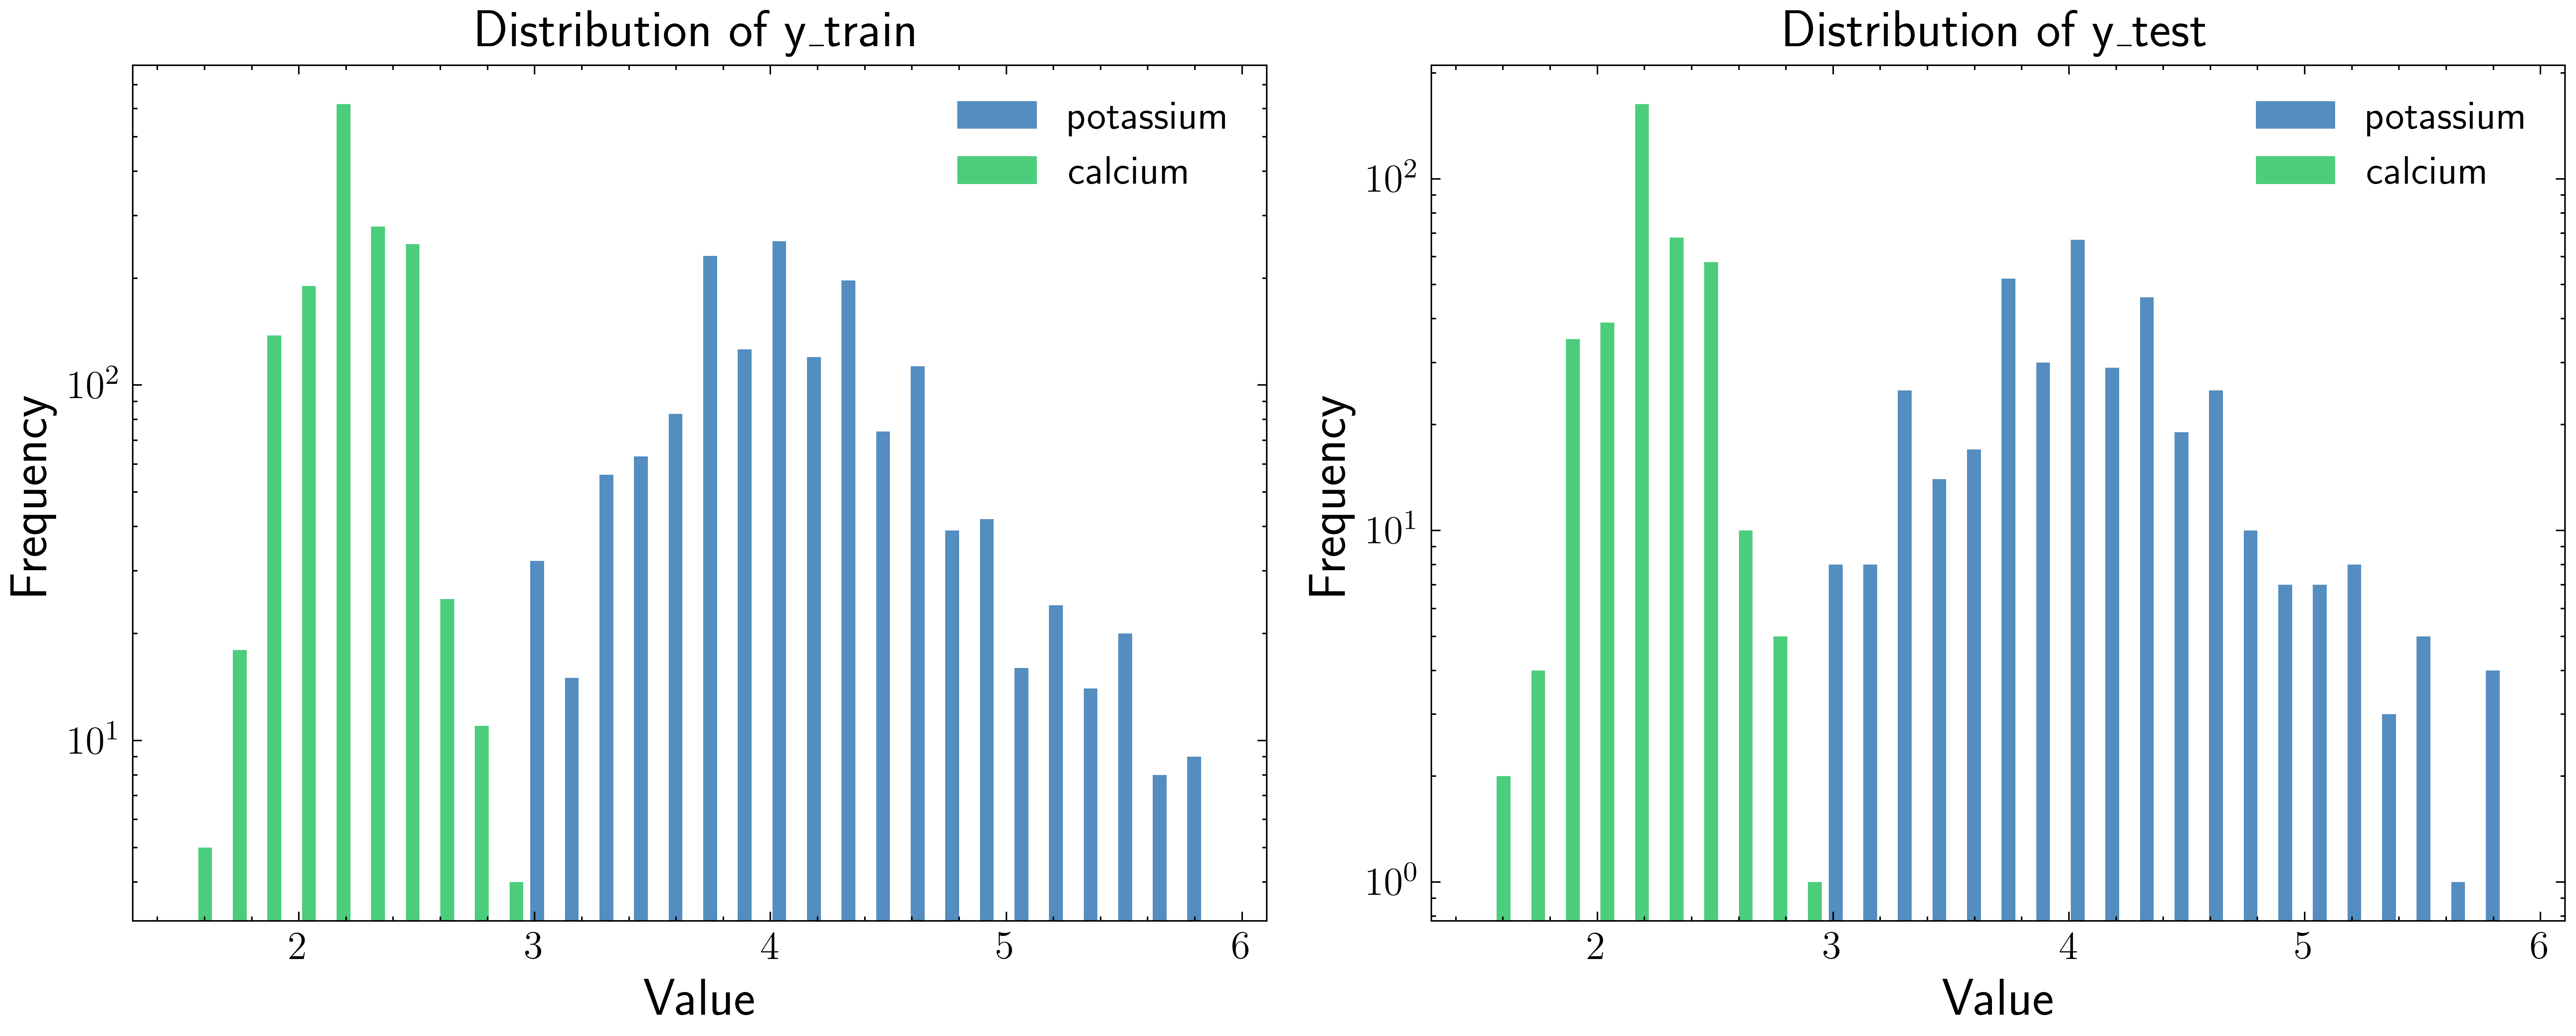

In [6]:
# Create histograms of training and test targets
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_train.numpy(), bins=30, alpha=0.7)
plt.title('Distribution of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(['potassium', 'calcium'])
plt.yscale('log')
plt.subplot(1,2,2)
plt.hist(y_test.numpy(), bins=30, alpha=0.7)
plt.title('Distribution of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(['potassium', 'calcium'])
plt.yscale('log')
plt.tight_layout()
plt.show()

# save as pt
torch.save((X_train, y_train, X_test, y_test),f"{DATASET_DIR}/dataset.pt")

# NOTE: example load
# X_train, y_train, X_test, y_test = torch.load(f"{DATASET_DIR}/dataset.pt")

---
# MORE
---

In [7]:
X_train, y_train, X_test, y_test = torch.load(f"{DATASET_DIR}/dataset.pt")

print(f"Train set size: {X_train.shape} \t with y shape: {y_train.shape}")
print(f"Test  set size: {X_test.shape} \t with y shape: {y_test.shape}")

Train set size: torch.Size([1536, 12, 512]) 	 with y shape: torch.Size([1536, 2])
Test  set size: torch.Size([385, 12, 512]) 	 with y shape: torch.Size([385, 2])


In [8]:
def clean_data(X, y):
    mask = ~torch.isnan(X).any(dim=(1, 2)) & ~torch.isnan(y).any(dim=1)
    return X[mask], y[mask]

X_train, y_train = clean_data(X_train, y_train)
X_test, y_test = clean_data(X_test, y_test)

print(f"Train set size: {X_train.shape} \t with y shape: {y_train.shape}")
print(f"Test  set size: {X_test.shape} \t with y shape: {y_test.shape}")

Train set size: torch.Size([1526, 12, 512]) 	 with y shape: torch.Size([1526, 2])
Test  set size: torch.Size([379, 12, 512]) 	 with y shape: torch.Size([379, 2])


In [9]:
torch.save((X_train, y_train, X_test, y_test),f"{DATASET_DIR}/dataset.pt")